In [7]:
!pip install -q transformers datasets evaluate


In [9]:
!pip install --upgrade transformers



     |████████████████████████████████| 7.2 MB 74 kB/s  eta 0:00:01     |████████████████████████▌       | 5.5 MB 3.4 MB/s eta 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.29.0
    Uninstalling transformers-4.29.0:
      Successfully uninstalled transformers-4.29.0


In [104]:
import torch
# from transformers import SegformerForImageSegmentation, SegformerFeatureExtractor
from datasets import load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split


In [105]:
import transformers
print(transformers.__version__)

4.30.2


In [290]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from torchvision import transforms

class COCOSegmentationDataset(Dataset):
    def __init__(self, root, ann_file, transforms_image=None, transforms_mask=None):
        """
        Args:
            root (str): Path to the root directory containing images.
            ann_file (str): Path to the COCO JSON file.
            transforms_image (callable, optional): Data transformations to apply to the image.
            transforms_mask (callable, optional): Data transformations to apply to the mask.
        """
        print("root ", root)
        print("ann_file ", ann_file)
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())
        self.transforms_image = transforms_image
        self.transforms_mask = transforms_mask

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        # Get image ID
        img_id = self.ids[index]
        
        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")
        
        print("img_path ",img_path)
        # Load annotations (segmentation masks)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Create a mask
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann) * ann['category_id'])
        mask = Image.fromarray(mask)  # Convert the mask to a PIL Image for augmentation

        # Apply transformations if specified
        if self.transforms_image and self.transforms_mask:
            seed = np.random.randint(2147483647)  # Generate a random seed for consistent transformations
            torch.manual_seed(seed)  # Set the seed for image transformations
            image = self.transforms_image(image)
            
            torch.manual_seed(seed)  # Set the same seed for mask transformations
            mask = self.transforms_mask(mask)

        return image, mask


In [291]:
def get_colormapping(coco_annotations_json,meta_json):
    coco = COCO(coco_annotations_json)
    categories = coco.loadCats(coco.getCatIds())
    name_id_map=dict()
    for cat in categories:
        name_id_map[cat["name"]] = cat["id"]
    with open(meta_json, 'r') as f:
        meta_data = json.load(f)
    id_to_colormap = dict()
    for obj in meta_data["classes"]:
        id_to_colormap[name_id_map[obj["title"]]] = obj["color"]
    
    return id_to_colormap

In [312]:
from torchvision.transforms import InterpolationMode,Compose, ColorJitter, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Normalize

def mask_to_tensor(mask):
    mask_tensor = transforms.functional.pil_to_tensor(mask).long()  # Keep integer labels
    return mask_tensor

def get_dataset(img_dir, ann_dir, is_train=False):
    if is_train:
        # Separate transformations for image and mask
        transforms_image = Compose([
            # transforms.Resize((594, 800)),
            RandomResizedCrop(size=(594, 800), scale=(0.8, 1.5), interpolation=InterpolationMode.BILINEAR),
            RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(torch.nn.ModuleList([ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),]), p=0.5),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        transforms_mask = transforms.Compose([
            # transforms.Resize((594, 800),interpolation=InterpolationMode.NEAREST),
            RandomResizedCrop(size=(594, 800), scale=(0.8, 1.5), interpolation=InterpolationMode.BILINEAR),
            RandomHorizontalFlip(p=0.5),
            mask_to_tensor
            # transforms.ToTensor()  # Convert mask to tensor
        ])
        append_str = "train"
    else:
        # Transformations for validation (no augmentation, only resizing and normalization)
        transforms_image = transforms.Compose([
            transforms.Resize((594, 800)),
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        transforms_mask = transforms.Compose([
            transforms.Resize((594, 800),interpolation=InterpolationMode.NEAREST),
            mask_to_tensor
            # transforms.ToTensor()
        ])
        append_str = "val"
    
    dataset = COCOSegmentationDataset(
        root=os.path.join(img_dir, append_str),
        ann_file=os.path.join(ann_dir, append_str + ".json"),
        transforms_image=transforms_image,
        transforms_mask=transforms_mask
    )
    return dataset


In [313]:
datadir = "./data/car-parts-and-car-damages/"
carparts_dir = os.path.join(datadir,"Car_parts_dataset")
cardamages_dir = os.path.join(datadir,"Car_damages_dataset")
carparts_imgs = os.path.join(carparts_dir,"split_dataset")
carparts_anns = os.path.join(carparts_dir,"split_annotations")
cardamages_imgs = os.path.join(cardamages_dir,"split_dataset")
cardamages_anns = os.path.join(cardamages_dir,"split_annotations")

In [314]:
cardamage_id_to_color = get_colormapping(cardamages_dir+"/coco_damage_annotations.json",cardamages_dir+"/meta.json")
cardamage_id_to_color

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


{3: '#13A4C9',
 2: '#A6FF47',
 6: '#B42D38',
 8: '#E19660',
 1: '#903C59',
 7: '#A7741B',
 4: '#B40E13',
 5: '#73C2CE'}

In [315]:
# Create dataset
train_cardamage_dataset = get_dataset(cardamages_imgs,cardamages_anns,is_train=True)
val_cardamage_dataset = get_dataset(cardamages_imgs,cardamages_anns)


root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/train.json
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/val
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/val.json
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [316]:
# Check an example
image, mask = train_cardamage_dataset[1]
print(image.shape, mask.shape)  # Tensor dimensions

img_path  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train/Car damages 647.png
torch.Size([3, 594, 800]) torch.Size([1, 594, 800])


In [317]:
with open('./mask.txt', 'w') as f:
    for m in mask.numpy()[0]:
        f.write("%s\n" % m)

In [356]:
def unnormalize_image(image_array, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Unnormalize an image tensor based on the given mean and std.

    Args:
        image_tensor (numpy array): The normalized image tensor.
        mean (list or tuple): The mean values used during normalization.
        std (list or tuple): The standard deviation values used during normalization.

    Returns:
        numpy array: The unnormalized image tensor.
    """
     # Ensure the array is in (H, W, C) format
    mean = np.array(mean).reshape(1, 1, -1)  # Reshape mean to (1, 1, C)
    std = np.array(std).reshape(1, 1, -1)    # Reshape std to (1, 1, C)

    # Reverse normalization
    unnormalized_image = image_array * std + mean
    unnormalized_image = (unnormalized_image * 255).clip(0, 255).astype(np.uint8)
    
    return unnormalized_image

In [388]:
import numpy as np
import cv2

def hex_to_rgb(hex_code):
    """Convert a hex color code to an RGB tuple."""
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4))

def overlay_colored_mask(image, mask, id_to_color, alpha=0.5):
    """
    Overlay a segmentation mask on an image using colors defined in meta.json.

    Args:
        image (numpy array): The image tensor (H, W, 3) in float32 format (normalized).
        mask (numpy array): The segmentation mask tensor (H, W) with class labels.
        id_to_color (dict): Stores mapping between category ID and color for it.
        alpha (float): Transparency for the mask overlay (0.0 to 1.0).

    Returns:
        overlayed_image (numpy array): The image with the mask overlay.
    """

    # Unnormalize the image
    image = unnormalize_image(image)

    # Ensure the image and mask dimensions match
    assert image.shape[:2] == mask.shape, "Image and mask dimensions do not match."

    # Initialize a blank color mask (H, W, 3)
    color_mask = np.zeros_like(image, dtype=np.uint8)

    # Fill the color mask based on the segmentation mask and id_to_color mapping
    for cls, color in id_to_color.items():
        rgb_color = hex_to_rgb(color)  # Convert hex color to RGB
        color_mask[mask == cls] = rgb_color  # Assign color to corresponding pixels

    # Step 3: Create a blended mask where mask != 0
    blended_image = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)

    # Step 4: Combine blended and original image based on mask
    overlayed_image = np.where(mask[..., None] != 0, blended_image, image)

    return overlayed_image


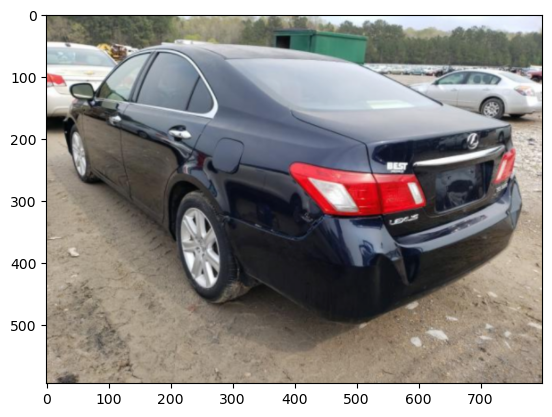

In [389]:
plt.imshow(unnormalize_image(image.transpose(0,-1).transpose(0,1).numpy()))

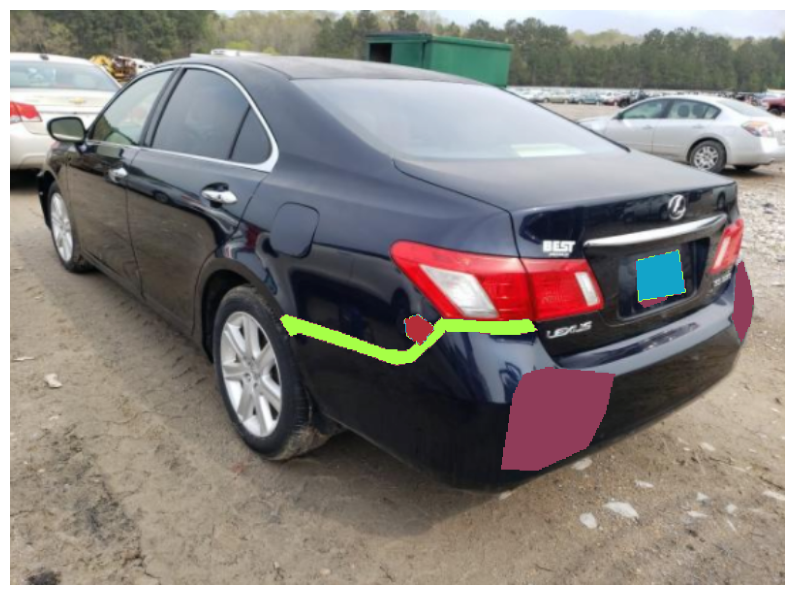

In [393]:
overlayed_image = overlay_colored_mask(image.transpose(0,-1).transpose(0,1).numpy(), mask[0].numpy(), cardamage_id_to_color, alpha=0.5)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [289]:
from torch.utils.data import DataLoader

# Create DataLoader
tr_cd_dataloader = DataLoader(train_cardamage_dataset, batch_size=8, shuffle=True)